<a href="https://colab.research.google.com/github/anshupandey/Generative-AI-for-Professionals/blob/main/EY2024/C13_SQL_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding LangChain Agents and Chains

In [1]:
# Installing necessary libraries
!pip install langchain-openai langchain langchain-core langchain-community --quiet
!pip install httpx langchain-experimental ace_tools langgraph --quiet
!pip install openai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 933.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/1

In [2]:
!wget -q https://raw.githubusercontent.com/anshupandey/Generative-AI-and-Prompt-Engineering/main/chinook_database.zip
!unzip -o -q chinook_database.zip

# Chains with LangChain

In [3]:
api_key = "xxxxxxxxxxxxxx"
api_version = "2024-02-01" # "2023-05-15"
azure_endpoint = "https://xxxxxxxxx.openai.azure.com/"
model_name = "gpt-4o"

In [4]:
import os
os.environ["OPENAI_API_VERSION"] = api_version
os.environ["AZURE_OPENAI_ENDPOINT"] = azure_endpoint
os.environ["AZURE_OPENAI_API_KEY"] = api_key
os.environ["AZURE_OPENAI_API_VERSION"] = api_version

## Implementing a database Integration Chain

In [5]:
from langchain_openai import AzureChatOpenAI
from langchain.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain

db = SQLDatabase.from_uri("sqlite:///chinook.db")
llm = AzureChatOpenAI(azure_deployment=model_name,temperature=0)
db_chain = create_sql_query_chain(llm, db)

- Approach 1: input + prompt emplate (DB Schema) --> LLM ---> (outputs query)---> tool (DB tool to execute query) ---> LLM ---> Final Response

- Approach 2: input + user cred --> F0 ---> Fetch the DB schema based on accessible tables ---> Prompt template + DB schema ----> LLM ---> (outputs query)---> tool (DB tool to execute query) ---> LLM ---> Final Response

In [6]:
db.run("""SELECT "name" FROM sqlite_master WHERE "type"='table';""")

"[('albums',), ('sqlite_sequence',), ('artists',), ('customers',), ('employees',), ('genres',), ('invoices',), ('invoice_items',), ('media_types',), ('playlists',), ('playlist_track',), ('tracks',), ('sqlite_stat1',)]"

In [7]:
response = db_chain.invoke({"question":"What are tables in availabe in the database?"})
print(response)

Question: What are tables available in the database?
SQLQuery: 
```sql
SELECT name 
FROM sqlite_master 
WHERE type='table';
```


In [8]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
exec_chain = QuerySQLDataBaseTool(db=db)

import re

def cleaner(query):
    pattern = re.compile(r"```(.*?)```",re.DOTALL)
    query = pattern.findall(query)[0]
    query = query[3:]
    query = query.replace("\n"," ")
    print(query)
    return query



final_Chain = db_chain | cleaner | exec_chain
final_Chain.invoke({"question":"What are tables in availabe in the database?"})

 SELECT name  FROM sqlite_master  WHERE type='table'; 


"[('albums',), ('sqlite_sequence',), ('artists',), ('customers',), ('employees',), ('genres',), ('invoices',), ('invoice_items',), ('media_types',), ('playlists',), ('playlist_track',), ('tracks',), ('sqlite_stat1',)]"

In [9]:
final_Chain.invoke({"question":"How many employees are there in total?"})

 SELECT COUNT("EmployeeId") AS "TotalEmployees" FROM "employees"; 


'[(8,)]'

In [10]:
final_Chain.invoke({"question":"who are most popular artists according to number of songs?"})

 SELECT "artists"."Name", COUNT("tracks"."TrackId") AS "NumberOfSongs" FROM "artists" JOIN "albums" ON "artists"."ArtistId" = "albums"."ArtistId" JOIN "tracks" ON "albums"."AlbumId" = "tracks"."AlbumId" GROUP BY "artists"."Name" ORDER BY "NumberOfSongs" DESC LIMIT 5; 


"[('Iron Maiden', 213), ('U2', 135), ('Led Zeppelin', 114), ('Metallica', 112), ('Lost', 92)]"

# SQL Agent

In [17]:
from langchain_community.agent_toolkits import create_sql_agent

db = SQLDatabase.from_uri("sqlite:///chinook.db")
llm = AzureChatOpenAI(azure_deployment=model_name,temperature=0)

agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=True)

In [18]:
agent_executor.invoke({"input": "what's the average age of customers"})


Invoking: `sql_db_list_tables` with `{}`


albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks
Invoking: `sql_db_schema` with `{'table_names': 'customers'}`



CREATE TABLE customers (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("SupportRepId") REFERENCES employees ("EmployeeId")
)

/*
3 rows from customers table:
CustomerId	FirstName	LastName	Company	Address	City	State	Country	PostalCode	Phone	Fax	Email	SupportRepId
1	Luís	Gonçalves	Embraer - Empresa Brasileira de Aeronáutica S.A.	Av. Brigadeiro Faria Lima, 2170	São José dos Campos	SP	Brazil	12227-000	+55 (12) 

{'input': "what's the average age of customers",
 'output': 'The `customers` table does not have an age column. Therefore, I cannot calculate the average age of customers from the available data.\n\nIf you have any other questions or need information from the database, please let me know!'}

In [20]:
agent_executor.invoke({"input": "who are the most popular artists based on number of songs"})


Invoking: `sql_db_list_tables` with `{}`


albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks
Invoking: `sql_db_schema` with `{'table_names': 'artists, tracks'}`



CREATE TABLE artists (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from artists table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE tracks (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Bytes" INTEGER, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("TrackId"), 
	FOREIGN KEY("MediaTypeId") REFERENCES media_types ("MediaTypeId"), 
	FOREIGN KEY("GenreId") REFERENCES genres ("GenreId"), 
	FOREIGN KEY("AlbumId") REFERENCES albums ("AlbumId")
)

/*
3 rows from tracks table:
TrackId	Name	AlbumId	MediaTypeId	GenreId	Composer	Millisecond

{'input': 'who are the most popular artists based on number of songs',
 'output': 'The most popular artists based on the number of songs are:\n\n1. Iron Maiden - 213 songs\n2. U2 - 135 songs\n3. Led Zeppelin - 114 songs\n4. Metallica - 112 songs\n5. Lost - 92 songs\n6. Deep Purple - 92 songs\n7. Pearl Jam - 67 songs\n8. Lenny Kravitz - 57 songs\n9. Various Artists - 56 songs\n10. The Office - 53 songs'}

In [21]:
agent_executor.invoke({"input": "What is AI?"})


Invoking: `sql_db_list_tables` with `{}`


albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksThe database contains tables related to music, such as albums, artists, customers, employees, genres, invoice items, invoices, media types, playlist tracks, playlists, and tracks. It does not seem to contain information about AI (Artificial Intelligence).

Therefore, the answer to your question "What is AI?" is not available in this database.

AI, or Artificial Intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. These systems can perform tasks such as recognizing speech, making decisions, and translating languages.

> Finished chain.


{'input': 'What is AI?',
 'output': 'The database contains tables related to music, such as albums, artists, customers, employees, genres, invoice items, invoices, media types, playlist tracks, playlists, and tracks. It does not seem to contain information about AI (Artificial Intelligence).\n\nTherefore, the answer to your question "What is AI?" is not available in this database.\n\nAI, or Artificial Intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. These systems can perform tasks such as recognizing speech, making decisions, and translating languages.'}

In [68]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78922b853a90>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78922b853a90>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78922b853a90>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [51]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools,) #messages_modifier=system_message

In [52]:
for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Which country's customers spent the most?")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2rJ6S9ZkaI29xsitkE53tqBx', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 325, 'total_tokens': 337, 'completion_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-1a503206-3310-47f6-9e2e-5a383a9a5057-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_2rJ6S9ZkaI29xsitkE53tqBx', 'type': 'tool_call'}],

In [53]:
for s in agent_executor.stream(
    {"messages": [HumanMessage(content="What is ARtificial Intelligence?")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='Artificial Intelligence (AI) is a branch of computer science that aims to create machines capable of performing tasks that typically require human intelligence. These tasks include, but are not limited to:\n\n1. **Learning**: The ability to improve performance based on past experiences.\n2. **Reasoning**: The ability to solve problems through logical deduction.\n3. **Perception**: The ability to interpret sensory information to understand the environment.\n4. **Language Understanding**: The ability to comprehend and generate human language.\n5. **Planning**: The ability to set and achieve goals.\n\nAI can be categorized into two main types:\n\n1. **Narrow AI (Weak AI)**: Designed and trained for a specific task, such as voice assistants (e.g., Siri, Alexa), recommendation systems, or self-driving cars.\n2. **General AI (Strong AI)**: A theoretical form of AI that possesses the ability to understand, learn, and apply knowledge across a wide ran

In [69]:
# custom tool

from langchain_core.tools import Tool
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO


def get_chart(data):
  csv_data = StringIO(data)
  # Converting the tuple to a DataFrame
  df = pd.read_csv(csv_data)

  # Creating a bar plot for the converted DataFrame
  plt.bar(df.iloc[:,0],df.iloc[:,1])

  # Adding labels and title
  plt.xlabel('Column1')
  plt.ylabel('Column2')
  plt.title('Bar Plot of Column1 vs Column2')

  # Displaying the plot
  plt.show()
  return "Chart generated successfully"

graph_tool = Tool(

    name="generate_chart",

    func=get_chart,

    description="Generates a chart for data retrived from sql query"

)


graph_tool


Tool(name='generate_chart', description='Generates a chart for data retrived from sql query', func=<function get_chart at 0x789223123a30>)

In [70]:
tools.append(graph_tool)

In [71]:
tools

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78922b853a90>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78922b853a90>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78922b853a90>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [72]:
agent_executor = create_react_agent(llm, tools,)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_D0BloZDF3WdNZLLgQDiqaOiT', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 361, 'total_tokens': 373, 'completion_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-ad5d2db9-7a54-4ff8-a544-41ac070ee064-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_D0BloZDF3WdNZLLgQDiqaOiT', 'type': 'tool_call'}],

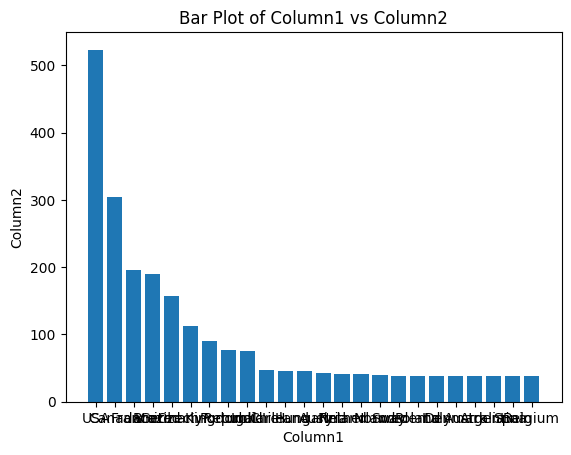

{'tools': {'messages': [ToolMessage(content='Chart generated successfully', name='generate_chart', tool_call_id='call_GSMwazAJ1g3fKeyR3iJ2o8Gf')]}}
----
{'agent': {'messages': [AIMessage(content='Here is the chart showing the total spending by customers from different countries:\n\n![Total Spending by Country](sandbox:/mnt/data/Total_Spending_by_Country.png)', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 1737, 'total_tokens': 1771, 'completion_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_resul

In [73]:
for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Which country's customers spent the most? Generate Graph for this")]}
):
    print(s)
    print("----")

In [ ]:
#

## Thank You